# TODO

- Make charts nicer, match in style, etc. 

# Intro

Goal of this notebook: 
- summarise Poisson distribution
- visualisations
- demonstrate maximum likelihood method
- debunking myth: frequency of claim number realisations should be Poisson

- log-link function calculations

In [1]:
import numpy as np
import pandas as pd
from scipy.special import factorial # for elementwise factorial calc of array
from scipy.special import xlogy # for special care with 0 log

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_poisson_deviance

In [2]:
from functions import poisson_likelihood, poisson_loglikelihood, poisson_loglikelihood2

# Poisson Summary

For reference: [wikipedia page](https://en.wikipedia.org/wiki/Poisson_distribution), lots of extra information there (like assumptions, real-life examples, etc.)

__Parameters__: $\lambda \in (0, \infty)$, this is the mean and variance as well  
<br>
__Probability Mass Function__: $Pr(X=k) = \displaystyle \frac{\lambda ^ {k} e ^ {- \lambda}} {k!}$
<br>

The following likelihood functions are the 'standard' approach, so we have observations from one specific distribution. 

__Likelihood__: $L(\lambda, x _{1}, ..., x _{n}) = \displaystyle \prod _{j=1} ^{n} \displaystyle \frac{\lambda ^ {x _{j}} e ^ {- \lambda}} {x _{j} !}$

__Log-likelihood__: $l(\lambda, x _{1}, ..., x _{n}) =  log(L(\lambda, x _{1}, ..., x _{n})) = log(\displaystyle \prod _{j=1} ^{n} \displaystyle \frac{\lambda ^ {x _{j}} e ^ {- \lambda}} {x _{j} !}) = \sum \limits _{j=1} ^{n} log (\displaystyle \frac{\lambda ^ {x _{j}} e ^ {- \lambda}} {x _{j} !}) = $
<br>
$ = log(\lambda) \sum \limits _{j=1} ^{n} x _{j} - n \lambda - \sum \limits _{j=1} ^{n} log(x _{j}!) $

However, in insurance, we basically need to calculate likelihoods row-wise, so there's not much point in writing formulas that assume the same predicted value (a.k.a. lambda). I think it's better to work with the following approach, and know that the likelihoods should be multiplied, while the individual log-likelihoods should be summed. 

With that, the functions I am going to use will assume two scalar inputs. 

__Likelihood__: $L(\lambda, k) = \displaystyle \frac{\lambda ^ {k} e ^ {- \lambda}} {k!}$
<br>

__Log-likelihood__: $l(\lambda, k) = log(L(\lambda, k)) = k * log(\lambda) -\lambda - log(k!)$

In [3]:
np.log(3) + np.log(5)

2.70805020110221

In [4]:
np.log(15)

2.70805020110221

In [5]:
poisson_likelihood(2, 0.5) == 0.5 ** 2 * np.exp(-0.5) / np.math.factorial(2)

True

In [6]:
poisson_likelihood(2, 0.5)

0.07581633246407918

In [7]:
poisson_loglikelihood(2, 0.5)

-2.5794415416798357

In [8]:
poisson_loglikelihood2(2, 0.5)

-2.5794415416798357

## Deviance

Testing the formula found here: https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models

More accurately, see the p = 1 mean_tweedie_deviance here, because the log needs special care when the actual is 0: https://github.com/scikit-learn/scikit-learn/blob/364c77e04/sklearn/metrics/_regression.py#L1095

In [9]:
def my_poisson_deviance(actu, pred):
    return(2 * (xlogy(actu, actu / pred) - actu + pred))

In [10]:
y_true = [2, 0, 1, 4]
y_pred = [0.5, 0.5, 2., 2.]
mean_poisson_deviance(y_true, y_pred)

1.4260151319598084

In [11]:
my_poisson_deviance(np.array(y_true), np.array(y_pred))

array([2.54517744, 1.        , 0.61370564, 1.54517744])

In [12]:
def my_mean_poisson_deviance(actu, pred):
    return(np.sum(my_poisson_deviance(actu,pred)) / len(actu))

In [13]:
my_mean_poisson_deviance(np.array(y_true), np.array(y_pred))

1.4260151319598084

And now let's check how deviance is derived from likelihood. 

In [14]:
my_poisson_deviance(2,0.5)

2.5451774444795623

In [15]:
-2 * (poisson_loglikelihood(2, 0.5) - poisson_loglikelihood(2,2))

2.5451774444795623

In summary, we now know how deviance is calculated, either from scratch with the likelihood or with a formula, yields the same results. 

# Generate Data

In [16]:
# variables
lambda1 = 0.85
n1 = 100000

In [17]:
# df1: simple simulated Poisson
df1 = pd.DataFrame.from_dict({'target': np.random.poisson(lambda1, n1)})

In [18]:
# df2: probabilities (likelihoods)
df2 = pd.DataFrame.from_dict({'target' : range(10)})
df2['likelihood'] = poisson_likelihood(df2['target'], lambda1)

# Visualisations

## Simulation

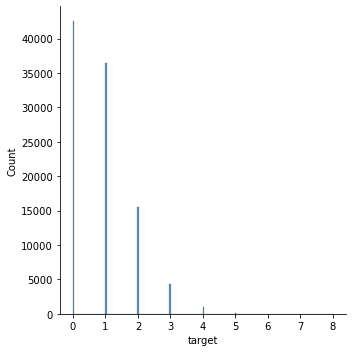

In [19]:
sns.displot(df1['target'])
plt.show()

## Likelihood

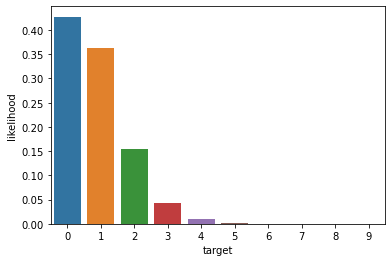

In [20]:
sns.barplot(x = df2['target'], y = df2['likelihood'])
plt.show()

# Maximum Likelihood Demonstration

Goal here: demonstrate that the highest likelihood is achieved with simply taking the average of observations. Meaning the maximum likelihood estimation is also the method of moments for a Poisson distribution. 

Of course, not proving anything, this is just a demonstration. Although the proof is not complicated either. 

__Poisson MLE__: $\hat{\lambda}_{n} = \displaystyle \frac{1} {n} 
\sum \limits _{j=1} ^{n} X_{n}   $

In [21]:
# we use ml1 to calculate the likelihood of different lambdas in the previous dataframe
ml1 = pd.DataFrame({'lambda':np.linspace(0.01,1.5,150)})

ml1['poisson_loglikelihood'] = ml1['lambda'].apply(lambda x: np.mean(poisson_loglikelihood(df1['target'], x)))

ml1.sort_values('poisson_loglikelihood')

,lambda,poisson_loglikelihood
0,0.01,-4.158359
1,0.02,-3.577701
2,0.03,-3.242188
3,0.04,-3.007043
4,0.05,-2.826893
...,...,...
82,0.83,-1.212889
86,0.87,-1.212781
83,0.84,-1.212683
85,0.86,-1.212632


In [22]:
np.round(np.mean(df1['target']),2)

0.85

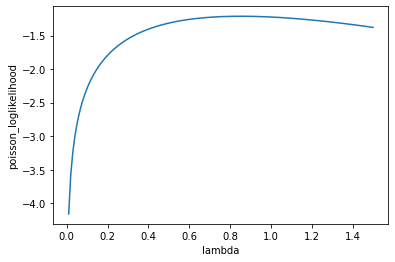

In [23]:
sns.lineplot(x = ml1['lambda'], y = ml1['poisson_loglikelihood'])
plt.show()

# Claim Occurence Table is not Poisson

If you look at the realised outcomes of a population with differing Poisson lambdas, the overall table is not going to be Poisson itself. 

Real-life example: in an insurance setting, we can assume that each individual policyholder's claim amount in a year is going to be Poisson-distributed, and it's the modelling phase's goal to estimate the value. If you look at one row, it will have a number, e.g. 0 claim, or 1 claim, etc, and we assume that to be Poisson. However, if we look at how many 0, 1, 2, ... claims we had overall, we don't expect that to be a Poisson. 

Confusion comes from the fact that sum of different Poissons is going to be a Poisson in itself, with lambda the sum of all the lambdas. But that's different. 

## Proof

Let's try to prove it mathematically. I mean, kinda mathematically, I reckon this is quite sloppy. 

Let's assume we have a random variable, X, which is $X _{1}$ ~ Poisson($\lambda_{1}$) with probability a, and $X _{2}$ ~ Poisson($\lambda_{2}$) with probability (1-a). X is meant to represent the whole population, which comes from different Poissons. The key thing is that this is not the same as a weighted average of Poissons. So X is __not the same__ as $a X_{1} + (1-a) X_{2}$.

We can define X as a discrete distribution where $Pr(X = k) = a Pr(X_{1} = k) + (1-a) Pr(X_{2} = k)$ for $k = 0,1,...$ (And let's observe how this is basically the claim frequency table, which will come from different Poissons. 

Let's assume that the above defined X is a Poisson with lambda parameter $\lambda$. We know that X's expected value is going to be 

$a \lambda_{1} + (1-a) \lambda_{2}$

Now, if X was of a Poisson distribution, its lambda parameter would equal its expected value. 

It is also true that:

$Pr(X = k) = a Pr(X_{1} = k) + (1-a) Pr(X_{2} = k)$

This holds for all k's. Let's assume that X is a Poisson with the lambda above, and use the Poisson probability function formula. 

$\displaystyle \frac{\lambda ^ {k} e ^ {- \lambda}} {k!} = a \displaystyle \frac{\lambda_{1} ^ {k} e ^ {- \lambda_{1}}} {k!} + (1-a) \displaystyle \frac{\lambda_{2} ^ {k} e ^ {- \lambda_{2}}} {k!}$


Using the expected value to calculate the lambda of the common assumed Poisson distribution: 

$\lambda = a \lambda_{1} + (1-a) \lambda_{2}$

in the above equation yields: 

$\displaystyle \frac{(a \lambda_{1} + (1-a) \lambda_{2}) ^ {k} e ^ {- (a \lambda_{1} + (1-a) \lambda_{2})}} {k!} = a \displaystyle \frac{\lambda_{1} ^ {k} e ^ {- \lambda_{1}}} {k!} + (1-a) \displaystyle \frac{\lambda_{2} ^ {k} e ^ {- \lambda_{2}}} {k!}$

This must be true for all values of k, let's see k = 0: 

$e ^ {- (a \lambda_{1} + (1-a) \lambda_{2})} = a e ^ {-\lambda_{1}} + (1-a) e ^ {-\lambda_{2}}$

which is not going to generally hold. It does hold of course if $\lambda_{1} = \lambda_{2}$, but that's hardly an interesting scenario, that would just mean that X1, X2, and X are all the exact same distribution. 

## Demonstration Through Example

Once again, simple case: we have a population with two different Poisson lambdas (think of it as a simple model with 1 binary variable). Can we find one specific Poisson lambda that is going to generate the same probabilities? 

In [24]:
a = 0.3 # ratio of population 1 in the database
lambda_1 = 0.05
lambda_2 = 0.5 # would be more obvious with larger differences but I wanted to keep it applicable to real life
n = 10000000

In [25]:
df = pd.DataFrame.from_dict({'lambda': np.random.choice(
    a = [lambda_1, lambda_2], size = n, p = [a, 1-a])})

df['target'] = np.random.poisson(df['lambda'])

In [26]:
df['target'].value_counts()

0    7099380
1    2266790
2     533522
3      87996
4      11152
5       1069
6         85
7          6
Name: target, dtype: int64

In [27]:
df['target'].mean()

0.3648327

In [28]:
a * lambda_1 + (1-a) * lambda_2

0.365

In [29]:
a * poisson_likelihood(1, lambda_1) + (1-a) * poisson_likelihood(1, lambda_2)

0.2265541722669324

In [30]:
len(df[df['target'] == 1]) / len(df)

0.226679

OK, so far I just wanted to demonstrate what the probability of a randomly selected row being equal to k is. It's a weighted average of two Poisson probabilities. 

Now, let's try to find one specific lambda_3 that solves for all k's. We need a solver function for that. 

In [31]:
from scipy.optimize import minimize

In [32]:
k = 0

In [33]:
def obj(arguments, a, k, lambda_1, lambda_2):
    """objective function, to be solved."""
    lambda_3 = arguments[0]
    diff = poisson_likelihood(k, lambda_3) - \
        (a * poisson_likelihood(k, lambda_1) + (1-a) * poisson_likelihood(k, lambda_2))
    return abs(diff)

In [34]:
estimated_lambda_3 = minimize(obj, x0 = (a*lambda_1 + (1-a)*lambda_2), args = (a, k, lambda_1, lambda_2))
estimated_lambda_3.x[0]

0.34257440503011105

Now that we have the function, let's summarise - what is the optimal lambda_3 for different k's? 

In [35]:
estimated_lambda_3s = []

start_k = 0
end_k = 6

for i in range(start_k,end_k):
    curr_estimated_lambda_3 = minimize(obj, x0 = 0.5, args = (a, i, lambda_1, lambda_2), bounds = [(0,1)]).x[0]
    estimated_lambda_3s.append(curr_estimated_lambda_3)
    

In [36]:
result_summary = df.from_dict({'k': range(start_k,end_k), 'lambda_3': estimated_lambda_3s})

In [37]:
result_summary

,k,lambda_3
0,0,0.342574
1,1,0.308394
2,2,0.399079
3,3,0.434455
4,4,0.451885
5,5,0.462056


There is a bit of funny business with the optimizations in higher k's. But the gist is quite straightforward: the singular lambda that would result in the corresponding probability will differ by k. 

In [40]:
# let's check that probabilities match with the given lambda

In [ ]:
result_summary[' ']

## Should it Differ Significantly in Real Life Though?

Let's try to investigate lambda's that are in a more realistic range.

In [39]:
a = 0.5
lambda_1 = 0.01
lambda_2 = 0.1

estimated_lambda_3s = []

start_k = 0
end_k = 4

for i in range(start_k,end_k):
    curr_estimated_lambda_3 = minimize(obj, x0 = 0.1, args = (a, i, lambda_1, lambda_2), bounds = [(0,1)]).x[0]
    estimated_lambda_3s.append(curr_estimated_lambda_3)

    
result_summary = df.from_dict({'k': range(start_k,end_k), 'lambda_3': estimated_lambda_3s})
result_summary

,k,lambda_3
0,0,0.053988
1,1,0.052920
2,2,0.070039
3,3,0.078841


TODO:
- extend function so you can define a list of lambdas and portions
- check minimize function manually at least a few times
- demonstrate real distribution vs estimated ones - so we have a baseline actual probability of 0s and 1s, and then depending on which lambda_common we use, the distribution will match for the corresponding k, but not the rest

# Log-link Calculations

The canonical link function for a Poisson regression (regardless of whether GLM or GBM) is the logarithm. 

This means that rather than predicting lambda itself, the model estimates a _raw_score_ in a linear fashion from the features, and then the final prediction is the exponential of this _raw_score_. 

This doesn't change the fact that we are maximising the sum of the log-likelihood, just by another format of the same variable. 

## Gradient and Hessian

The gradient and hessian used in the gradient descent methods is the first and second order derivative of the log-likelihood function with respect to the predicted value. The important tweak is that this is the predicted raw score, not the final predicted value. 

First, we have to re-work the log-likelihood function. 

if $\lambda _{raw} = log(\lambda) $, then $\lambda = e ^{\lambda _{raw}}$, and we can re-write the log-likelihood formula: 

$l(\lambda, k) = log(L(\lambda, k)) = k * log(\lambda) -\lambda - log(k!) = k * log(e ^{\lambda _{raw}}) -e ^{\lambda _{raw}} - log(k!) = k * \lambda _{raw} - e ^{\lambda _{raw}} - log(k!)$
<br>
<br>
The gradient is going to be the derivative by $\lambda _{raw}$
<br>
$G(\lambda _{raw}, k) = \displaystyle \frac {d(l(\lambda _{raw}, k))} {d \lambda _{raw}} = k - e ^{\lambda _{raw}} = k - \lambda$
<br>
This is the usual actu - pred result. 
Hessian is one additional derivation, which is going to be simply $\lambda$, so pred. Need to be careful with the signs though!

## Deviance

(Note: 0's are ignored, the log should be always separated for them. But this is the gist.)

Excerpt from sklearn GLM [HalfPoissonLoss](https://github.com/scikit-learn/scikit-learn/blob/14995509a996ff5575c032fb7aead25bf6bb595c/sklearn/_loss/loss.py#L700):

    For a given sample x_i, half the Poisson deviance is defined as::

        loss(x_i) = y_true_i * log(y_true_i/exp(raw_prediction_i))
                    - y_true_i + exp(raw_prediction_i)
                    
    Half the Poisson deviance is actually the negative log-likelihood up to
    constant terms (not involving raw_prediction) and simplifies the
    computation of the gradients.
    We also skip the constant term `y_true_i * log(y_true_i) - y_true_i`.

Another (probably better documented) example from sklearn [regression metrics](https://github.com/scikit-learn/scikit-learn/blob/7f9bad99d/sklearn/metrics/_regression.py#L1184):

        # Poisson distribution
        dev = 2 * (xlogy(y_true, y_true / y_pred) - y_true + y_pred)



deviance = - 2 * (log-likelihood of fitted model - log-likelihood of saturated model)

in the saturated model, we can simply use $log(k)$ instead of $\lambda _{raw}$

log-likelihood of model: $\sum \limits _k k  \lambda _{raw} - e ^{\lambda _{raw}} - log(k!)$

$D = -2(\sum \limits _k k  \lambda _{raw} - e ^{\lambda _{raw}} - log(k!) - \sum \limits _k k  log(k) - k - log(k!)) = $

$-2(\sum \limits _k k  \lambda _{raw} - e ^{\lambda _{raw}} - log(k!) - k  log(k) + k + log(k!)) = $

$-2(\sum \limits _k k  \lambda _{raw} - e ^{\lambda _{raw}} - k  log(k) + k ) = $

$2(\sum \limits _k k  (log(k) -\lambda _{raw}) - k + e ^{\lambda _{raw}}) = $

$2(\sum \limits _k k  (log(k) -log(\lambda)) - k + \lambda) = $

$2(\sum \limits _k k  (log(k / \lambda)) - k + \lambda)$